In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import h5py
import os
import cv2
from sklearn.decomposition import PCA
from pathlib import Path
import scipy.signal as ss
import scipy.ndimage as sn
from astropy.io import fits
from kink import detect_kinks
import pickle
from sklearn.linear_model import LinearRegression


In [13]:
flare_catalog = pd.read_csv('aia_flares_catalog_verified.csv')
flare_catalog_goes = flare_catalog[flare_catalog['goes_flare_ind'].notnull()]
flare_catalog_nogoes = flare_catalog[flare_catalog['goes_flare_ind'].isnull()]
goes_catalog = pd.read_csv('goes_catalog_with_noaa_ar2.csv',na_values=' ')
goes_catalog = goes_catalog.dropna(subset=['SHARP'])
goes_catalog = goes_catalog[pd.to_numeric(goes_catalog['SHARP'])>=20]
goes_catalog.SHARP = pd.to_numeric(goes_catalog['SHARP']).astype('int64')

bhs = pd.read_csv('/home/kiva6588/Code/sharps_badheaders.csv')
bhs = [x[0] for x in bhs.values]
goes_catalog = goes_catalog[~goes_catalog.SHARP.isin(bhs)]

outofrange = pd.read_csv('/home/kiva6588/Code/flares_with_limbs2.csv')
outofrange = [x[0] for x in outofrange.values]
goes_catalog = goes_catalog.drop(outofrange,errors='ignore')

nes_noaa = pd.read_csv('/home/kiva6588/Code/nonempty_sharps_with_noaa_ar.csv')
goes_catalog = goes_catalog[goes_catalog.SHARP.isin(nes_noaa.HARPNUM)]
goes_catalog = goes_catalog.reset_index().rename(columns={'index':'flare_ind'})

lams = ['193','171','304','1600','131','94']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']


In [4]:
print(len(flare_catalog_goes),len(flare_catalog_nogoes))
print(len(goes_catalog))
print(len(flare_catalog_goes)/len(goes_catalog))
print('B:',sum(goes_catalog['CMX']=='B'),'C:',sum(goes_catalog['CMX']=='C'),'M:',sum(goes_catalog['CMX']=='M'),'X:',sum(goes_catalog['CMX']=='X'))

3104 13109
4959
0.6259326477112321
B: 1807 C: 2825 M: 305 X: 22


Flares detected from AIA and cross-referenced with GOES
B:  339
C:  2379
M:  361
X:  25
>=C5:  770
Flares in GOES but not detected from AIA:
B: 1472
C: 610
M: 13
X: 1
>=C5: 82
Flares not in GOES but estimated from ERT using AIA:
C:  13017
M:  89
X:  3
>=C5:  495


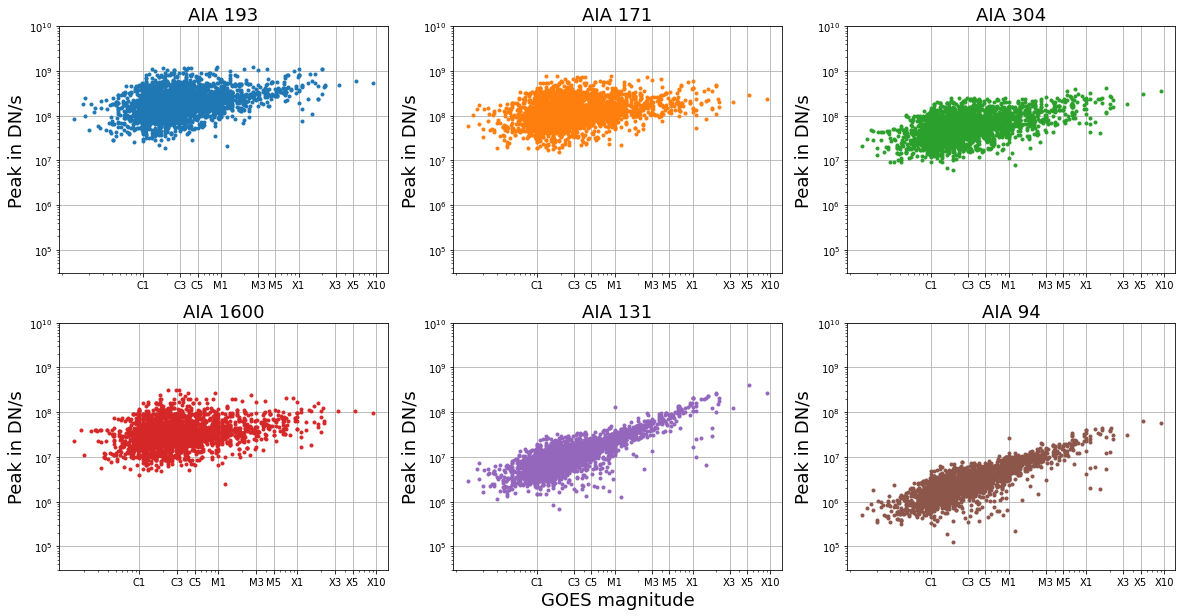

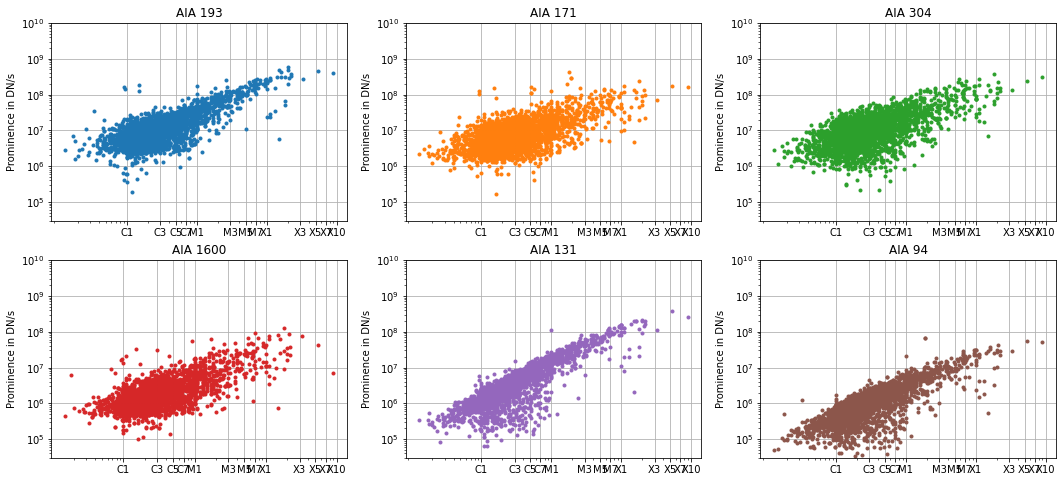

In [5]:
fig2,axs2 = plt.subplots(2,3,figsize=(20,10))
for j in range(len(lams)):
    ax = axs2[j//3,j-j//3*3]
    ax.loglog((flare_catalog_goes['goes_magnitude']),(flare_catalog_goes[lams[j]+'_magnitude']),'.',color=colors[j])
    ax.set_title('AIA '+lams[j],fontsize=18)
    ax.set_ylabel('Peak in DN/s',fontsize=18)
    ax.set_ylim(3e4,1e10)
    ax.grid(True,axis='both')
    ax.set_xticks(ticks=([1e-6,3e-6,5e-6,1e-5,3e-5,5e-5,1e-4,3e-4,5e-4,1e-3]))
    ax.set_xticklabels(labels=['C1','C3','C5','M1','M3','M5','X1','X3','X5','X10'])
axs2[1,1].set_xlabel('GOES magnitude',fontsize=18)

fig3,axs3 = plt.subplots(2,3,figsize=(18,8))
for j in range(len(lams)):
    ax = axs3[j//3,j-j//3*3]
    ax.loglog((flare_catalog_goes['goes_magnitude']),(flare_catalog_goes[lams[j]+'_prominence']),'.',color=colors[j])
    ax.set_title('AIA '+lams[j])
    ax.set_ylabel('Prominence in DN/s')
    ax.set_ylim(3e4,1e10)
    ax.grid()
    ax.set_xticks(ticks=([1e-6,3e-6,5e-6,7e-6,1e-5,3e-5,5e-5,7e-5,1e-4,3e-4,5e-4,7e-4,1e-3]))
    ax.set_xticklabels(labels=['C1','C3','C5','C7','M1','M3','M5','M7','X1','X3','X5','X7','X10'])
print('Flares detected from AIA and cross-referenced with GOES')
print('B: ',len(flare_catalog_goes[flare_catalog_goes['CMX']=='B']))
print('C: ',len(flare_catalog_goes[flare_catalog_goes['CMX']=='C']))
print('M: ',len(flare_catalog_goes[flare_catalog_goes['CMX']=='M']))
print('X: ',len(flare_catalog_goes[flare_catalog_goes['CMX']=='X']))
print('>=C5: ',len(flare_catalog_goes[flare_catalog_goes['goes_magnitude']>=5e-6]))
print('Flares in GOES but not detected from AIA:')
print('B:',len(goes_catalog[np.logical_and(goes_catalog['CMX']=='B',~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]))
print('C:',len(goes_catalog[np.logical_and(goes_catalog['CMX']=='C',~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]))
print('M:',len(goes_catalog[np.logical_and(goes_catalog['CMX']=='M',~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]))
print('X:',len(goes_catalog[np.logical_and(goes_catalog['CMX']=='X',~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]))
print('>=C5:',len(goes_catalog[np.logical_and(goes_catalog['INTENSITY']/10>=5e-6,~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]))
print('Flares not in GOES but estimated from ERT using AIA:')
print('C: ',len(flare_catalog_nogoes[flare_catalog_nogoes['ert_pred_CMX']=='C']))
print('M: ',len(flare_catalog_nogoes[flare_catalog_nogoes['ert_pred_CMX']=='M']))
print('X: ',len(flare_catalog_nogoes[flare_catalog_nogoes['ert_pred_CMX']=='X']))
print('>=C5: ',len(flare_catalog_nogoes[flare_catalog_nogoes['ert_pred_intensity']>=5e-6]))

Flares detected in AIA but not in GOES:
Total: 13109
~>=M1 (peak >=1.5e7 in 131 and >=4e6 in 94): 1155
~>=M5 (peak >=5e7 in 131 and >=1e7 in 94): 27


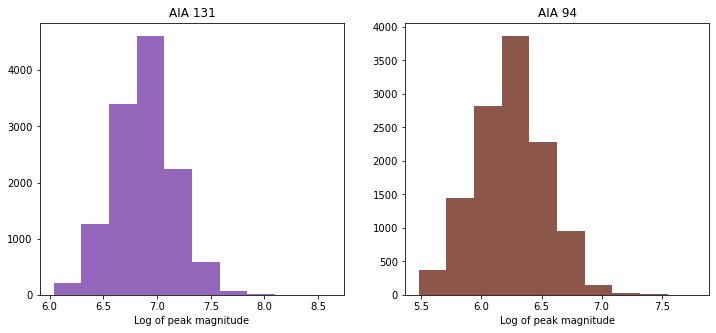

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(np.log10(flare_catalog_nogoes['131_magnitude']),color=colors[-2])
ax[0].set_title('AIA 131')
ax[0].set_xlabel('Log of peak magnitude')
ax[1].hist(np.log10(flare_catalog_nogoes['94_magnitude']),color=colors[-1])
ax[1].set_title('AIA 94')
ax[1].set_xlabel('Log of peak magnitude')
print('Flares detected in AIA but not in GOES:')
print('Total:',len(flare_catalog_nogoes))
print('~>=M1 (peak >=1.5e7 in 131 and >=4e6 in 94):',np.sum(np.logical_and(flare_catalog_nogoes['131_magnitude']>=1.5e7,flare_catalog_nogoes['94_magnitude']>=4e6)))
print('~>=M5 (peak >=5e7 in 131 and >=1e7 in 94):',np.sum(np.logical_and(flare_catalog_nogoes['131_magnitude']>=5e7,flare_catalog_nogoes['94_magnitude']>=1e7)))

In [7]:
missing_X = goes_catalog[np.logical_and(goes_catalog['CMX']=='X',~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]
print(missing_X)

      flare_ind    DATE  START_TIME  END_TIME MAX_TIME LOCATION CMX  \
4944       6989  170910        1535      1631      NaN      NaN   X   

      CMX_VALUE  INTENSITY  FLUX     AR  SHARP  
4944         82      0.008   NaN  12673   7115  


% L2 error:  5.637714317567762
% L1 error:  4.271005990531162
% L2 error on MX flares only:  12.093810326796943
% L1 error on MX flares only:  9.760479233781048
% L2 error:  6.143840856508217
% L1 error:  4.786926132951795
% L2 error on MX flares only:  13.109908145185154
% L1 error on MX flares only:  11.069248447443528


Text(0.5, 1.0, 'Predicted vs True (log of intensity) based on AIA 131 peak prominence')

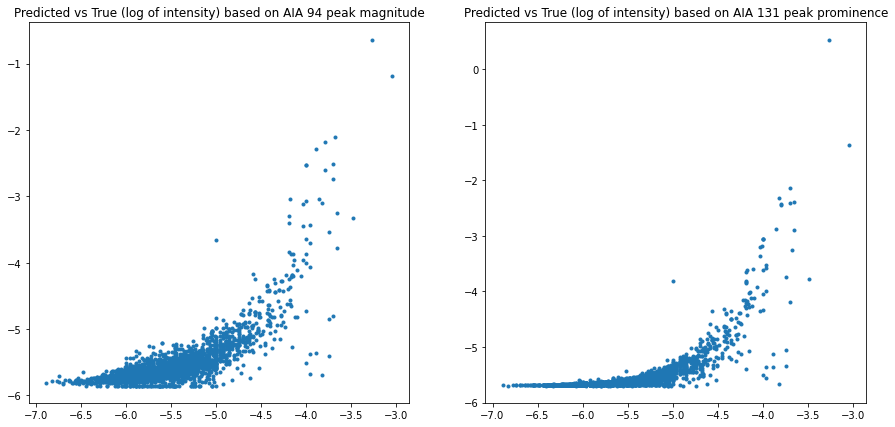

In [8]:
regressor = LinearRegression(fit_intercept = True,normalize=False)
y_true = np.log10(flare_catalog_goes['goes_magnitude'])
x = np.array(flare_catalog_goes['94_magnitude'].replace([np.nan],0)).reshape(-1,1)
regressor.fit(x,np.array(y_true))
y_pred = regressor.predict(x)

print('% L2 error: ', np.sqrt(np.sum((y_pred-y_true)**2)/np.sum(y_true**2))*100)
print('% L1 error: ', np.sum(np.abs(y_pred-y_true))/np.sum(np.abs(y_true))*100)
print('% L2 error on MX flares only: ', np.sqrt(np.sum((y_pred[y_true>=-5]-y_true[y_true>=-5])**2)/np.sum(y_true[y_true>=-5]**2))*100)
print('% L1 error on MX flares only: ', np.sum(np.abs(y_pred[y_true>=-5]-y_true[y_true>=-5]))/np.sum(np.abs(y_true[y_true>=-5]))*100)

regressor2 = LinearRegression(fit_intercept = True,normalize=False)
y_true = np.log10(flare_catalog_goes['goes_magnitude'])
x_2 = np.array(flare_catalog_goes['131_prominence'].replace([np.nan],0)).reshape(-1,1)
regressor2.fit(x_2,np.array(y_true))
y_pred_2 = regressor2.predict(x_2)

print('% L2 error: ', np.sqrt(np.sum((y_pred_2-y_true)**2)/np.sum(y_true**2))*100)
print('% L1 error: ', np.sum(np.abs(y_pred_2-y_true))/np.sum(np.abs(y_true))*100)
print('% L2 error on MX flares only: ', np.sqrt(np.sum((y_pred_2[y_true>=-5]-y_true[y_true>=-5])**2)/np.sum(y_true[y_true>=-5]**2))*100)
print('% L1 error on MX flares only: ', np.sum(np.abs(y_pred_2[y_true>=-5]-y_true[y_true>=-5]))/np.sum(np.abs(y_true[y_true>=-5]))*100)


fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].plot(y_true,y_pred,'.')
ax[0].set_title('Predicted vs True (log of intensity) based on AIA 94 peak magnitude')
ax[1].plot(y_true,y_pred_2,'.')
ax[1].set_title('Predicted vs True (log of intensity) based on AIA 131 peak prominence')

In [14]:
flares_MX = flare_catalog_goes[flare_catalog_goes['goes_magnitude']>=1e-5]
print(flares_MX[flares_MX.duplicated(keep=False,subset=['goes_flare_ind'])])
print(len(flares_MX))

       SHARP  goes_flare_ind CMX  CMX_VALUE  goes_magnitude  goes_start_time  \
77      1028          2363.0   M       12.0        0.000012   11/6/2011 0:46   
144     1028          2363.0   M       12.0        0.000012   11/6/2011 0:46   
1334    1621          2791.0   M       19.0        0.000019   5/7/2012 14:03   
1337    1621          2791.0   M       19.0        0.000019   5/7/2012 14:03   
2372    1834          3079.0   M       17.0        0.000017   7/10/2012 4:58   
...      ...             ...  ..        ...             ...              ...   
15238    750          1882.0   M       14.0        0.000014    8/2/2011 5:19   
15239    750          1882.0   M       14.0        0.000014    8/2/2011 5:19   
15312    750          1882.0   M       14.0        0.000014    8/2/2011 5:19   
15761    856          2161.0   M       28.0        0.000028  9/24/2011 17:59   
15843    892          2161.0   M       28.0        0.000028  9/24/2011 17:59   

         goes_end_time  193_peak_time 1

In [15]:

starts = np.zeros((len(flares_MX),len(lams)))
ends = np.zeros((len(flares_MX),len(lams)))
peaks = np.zeros((len(flares_MX),len(lams)))

# convert all time columns to datetimes
# flares_MX['aia_max_start_time'] = pd.to_datetime(flares_MX['aia_max_start_time'])
# flares_MX['aia_min_end_time'] = pd.to_datetime(flares_MX['aia_min_end_time'])
flares_MX['goes_start_time'] = pd.to_datetime(flares_MX['goes_start_time'])
flares_MX['goes_end_time'] = pd.to_datetime(flares_MX['goes_end_time'])

for j in range(len(lams)):
    lam = lams[j]
    flares_MX[lam+'_start_time'] = pd.to_datetime(flares_MX[lam+'_start_time'])
    flares_MX[lam+'_peak_time'] = pd.to_datetime(flares_MX[lam+'_peak_time'])
    flares_MX[lam+'_end_time'] = pd.to_datetime(flares_MX[lam+'_end_time'])
    flares_MX[lam+'_starts'] = flares_MX[lam+'_start_time'].subtract(flares_MX['goes_start_time']).dt.total_seconds()/60
    flares_MX[lam+'_peaks'] = flares_MX[lam+'_peak_time'].subtract(flares_MX[lam+'_start_time']).dt.total_seconds()/60
    flares_MX[lam+'_ends'] = flares_MX[lam+'_end_time'].subtract(flares_MX[lam+'_start_time']).dt.total_seconds()/60
    starts[:,j] = flares_MX[lam+'_starts']
    peaks[:,j] = flares_MX[lam+'_peaks']
    ends[:,j] = flares_MX[lam+'_ends']
    print('Mean+/-std,median start time diff for AIA ', lam, ': ',flares_MX[lam+'_starts'].mean(), '+/-',flares_MX[lam+'_starts'].std(),',',flares_MX[lam+'_starts'].median())
    print('Mean+/-std,median peak time diff for AIA ', lam, ': ',flares_MX[lam+'_peaks'].mean(), '+/-',flares_MX[lam+'_peaks'].std(),',',flares_MX[lam+'_peaks'].median())

flares_MX['aia_max_start_time']  = flares_MX[[lam+'_start_time'for lam in lams]].max(axis=1)
flares_MX['aia_min_start_time']  = flares_MX[[lam+'_end_time'for lam in lams]].min(axis=1)

    # print(flares_MX[flares_MX[lam+'_starts']<-60])


Mean+/-std,median start time diff for AIA  193 :  5.7356020942408374 +/- 175.0828697362933 , 0.5000000000000001
Mean+/-std,median peak time diff for AIA  193 :  15.049738219895287 +/- 22.194206934549406 , 9.0
Mean+/-std,median start time diff for AIA  171 :  11.12532637075718 +/- 158.85804839586154 , 0.0
Mean+/-std,median peak time diff for AIA  171 :  12.968668407310705 +/- 14.077536227362032 , 7.0
Mean+/-std,median start time diff for AIA  304 :  7.472727272727273 +/- 158.1203388940515 , 0.0
Mean+/-std,median peak time diff for AIA  304 :  14.25974025974026 +/- 13.915109628530635 , 8.000000000000002
Mean+/-std,median start time diff for AIA  1600 :  8.263707571801566 +/- 157.93630140803063 , -1.0000000000000002
Mean+/-std,median peak time diff for AIA  1600 :  9.681462140992167 +/- 10.057835160626135 , 6.0
Mean+/-std,median start time diff for AIA  131 :  5.205729166666667 +/- 173.16267685730082 , 0.0
Mean+/-std,median peak time diff for AIA  131 :  15.0390625 +/- 11.609667132194856 

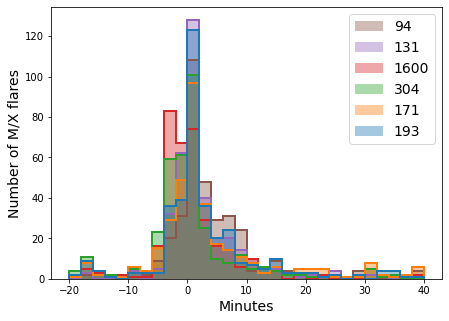

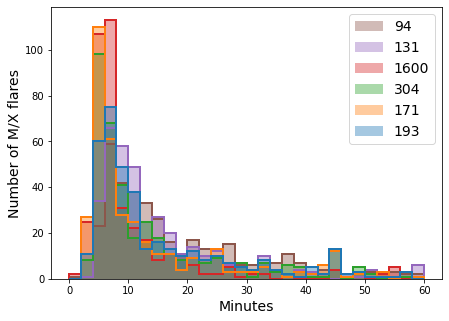

In [16]:
fig1 = plt.figure(figsize=(7,5))
# plt.title('Time from GOES start to AIA start',fontsize=14)
plt.xlabel('Minutes',fontsize=14)
plt.ylabel('Number of M/X flares',fontsize=14)

# axs2[2].set_title('Difference between AIA end time and AIA start time')
# axs2[2].set_xlabel('Minutes')
# axs2[2].set_ylabel('Probability')
plt.hist((starts[~np.isnan(starts)[:,0],0],starts[~np.isnan(starts)[:,1],1],starts[~np.isnan(starts)[:,2],2],starts[~np.isnan(starts)[:,3],3],starts[~np.isnan(starts)[:,4],4],starts[~np.isnan(starts)[:,5],5]),range=(-20,40),bins=30,density=False,histtype='stepfilled',alpha=0.4,color=colors)
plt.hist((starts[~np.isnan(starts)[:,0],0],starts[~np.isnan(starts)[:,1],1],starts[~np.isnan(starts)[:,2],2],starts[~np.isnan(starts)[:,3],3],starts[~np.isnan(starts)[:,4],4],starts[~np.isnan(starts)[:,5],5]),range=(-20,40),bins=30,density=False,histtype='step',alpha=1,linewidth=2,color=colors)
plt.legend(lams[::-1],fontsize=14)

fig2 = plt.figure(figsize=(7,5))
# plt.title('Time from AIA start to AIA peak',fontsize=14)
plt.xlabel('Minutes',fontsize=14)
plt.ylabel('Number of M/X flares',fontsize=14)
plt.hist((peaks[~np.isnan(peaks)[:,0],0],peaks[~np.isnan(peaks)[:,1],1],peaks[~np.isnan(peaks)[:,2],2],peaks[~np.isnan(peaks)[:,3],3],peaks[~np.isnan(peaks)[:,4],4],peaks[~np.isnan(peaks)[:,5],5]),range=(0,60),bins=30,density=False,histtype='stepfilled',alpha=0.4,color=colors)
plt.hist((peaks[~np.isnan(peaks)[:,0],0],peaks[~np.isnan(peaks)[:,1],1],peaks[~np.isnan(peaks)[:,2],2],peaks[~np.isnan(peaks)[:,3],3],peaks[~np.isnan(peaks)[:,4],4],peaks[~np.isnan(peaks)[:,5],5]),range=(0,60),bins=30,density=False,histtype='step',alpha=1,linewidth=2,color=colors)
plt.legend(lams[::-1],fontsize=14)
# axs2[2].hist((ends[~np.isnan(ends)[:,0],0],ends[~np.isnan(ends)[:,1],1],ends[~np.isnan(ends)[:,2],2],ends[~np.isnan(ends)[:,3],3],ends[~np.isnan(ends)[:,4],4],ends[~np.isnan(ends)[:,5],5]),bins=50,density=True,histtype='stepfilled',alpha=0.5,range=(0,50));

(2, 19)


,seed,RMSE_train,MAE_train,R2_train,L2err_train,RMSE_test,MAE_test,R2_test,L2err_test
0,1001,0.191221,0.137457,0.813725,8.163193,0.396569,0.300917,0.210368,15.900994
1,2001,0.186617,0.136889,0.823155,7.547546,0.384021,0.287813,0.249794,16.080546


<Figure size 4000x4000 with 0 Axes>

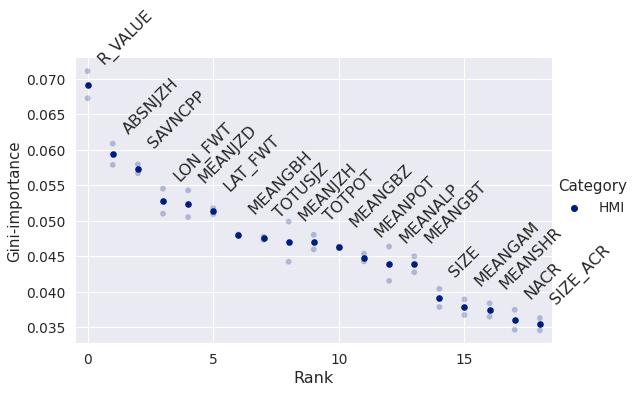

In [20]:
ert_results = pd.read_csv('ert_results_hmi/seed2001/ert_results_hmi_verified.csv')
ert_metrics = ert_results.iloc[:,:9]
ert_features = ert_results.iloc[:,list(range(9,len(ert_results.columns)))]
mean_features = np.mean(ert_features.iloc[:,:],axis=0)
rank = np.argsort(mean_features)
# print(rank)
ert_features = ert_features.iloc[:,rank[:2:-1]]
# print(len(rank))
print(ert_features.shape)
# replace features with rank
features = ert_features.columns
# ert_features.set_axis(np.arange(len(features)),axis=1,inplace=True)
# print(ert_features)
ert_features_long = ert_features.melt(var_name="Features",value_name="Gini-importance")
# ert_features_long['Rank'] = np.arange(len(ert_features_long))
ert_features_long['Category'] = 0
ert_features_long.loc[ert_features_long.iloc[:,0] =='SIZE','Category'] = 'GOES'
ert_features_long.loc[ert_features_long.iloc[:,0].str.isupper(),'Category']='HMI'
ert_features_long.loc[~ert_features_long.iloc[:,0].str.isupper(),'Category'] = 'AIA'

plt.figure(dpi=500,figsize=(8,8))
sns.set(rc={'figure.figsize':(11.7,8.27)},font_scale=1.25)
_categories = ['AIA','HMI']
g = sns.relplot(data=ert_features_long, x='Features', y='Gini-importance',hue='Category',palette='dark',alpha=.25, aspect=1.61)
# sns.move_legend(g,'upper right',bbox_to_anchor=(0.8,0.8))
sns.pointplot(data=ert_features_long,x="Features",y="Gini-importance",hue='Category',palette='dark',join=False,scale=.75,ci=None)
plt.legend([],[],frameon=False)
plt.grid(True,axis='both')
plt.xticks(range(0,len(features)+1,5),range(0,len(features)+1,5))
plt.xlabel('Rank',fontsize=16)
features = pd.DataFrame({'Feature':features,'Rank':range(len(features)),'Gini-importance':mean_features[rank[:2:-1]]})
features.reset_index
for v in features.iterrows():
    plt.text(v[1][1] + 0.3, v[1][2] + 0.003, f'{v[1][0]}', rotation=45, fontsize=16)
ert_metrics

In [21]:
mean_metrics = np.mean(ert_metrics.iloc[:,1:],axis=0)
std_metrics = np.std(ert_metrics.iloc[:,1:],axis=0)
print(mean_metrics)
print(std_metrics)

RMSE_train      0.188919
MAE_train       0.137173
R2_train        0.818440
L2err_train     7.855370
RMSE_test       0.390295
MAE_test        0.294365
R2_test         0.230081
L2err_test     15.990770
dtype: float64
RMSE_train     0.002302
MAE_train      0.000284
R2_train       0.004715
L2err_train    0.307823
RMSE_test      0.006274
MAE_test       0.006552
R2_test        0.019713
L2err_test     0.089776
dtype: float64
